In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import normalize as nr
from scipy.constants import c, h, k
from scipy.optimize import curve_fit, least_squares
from scipy.integrate import quad
currentdir = os.getcwd()
homefolder = os.path.dirname(os.getcwd())

In [13]:
wl = np.array([0.548, 0.586, 0.628, 0.667, 0.704, 0.743, 0.786, 0.82])*10**(-6)

experiment_folder = homefolder+"/hyper/data/T1899_3_digital/"
camera_folder = homefolder+"/hyper/camera_parameter/"

DF_QE = pd.read_excel(camera_folder+"CMS22010236.xlsx",'QE')
DF_T = pd.read_excel(camera_folder+"FIFO-Lens_tr.xlsx")
data = []
for i in range(8):
    data.append(pd.read_excel(experiment_folder+"digital_value_1899.xlsx","channel_"+str(i),header=None))
data = np.array(data)
DF_DV = pd.read_excel(experiment_folder+"digital_value_1899.xlsx")
tr_array = np.array(DF_T).transpose()
qe_array = []
for i in range(8):
    qe_array.append(DF_QE.iloc[:, [0,1+i]])
qe_array = np.array(qe_array).transpose(0,2,1)

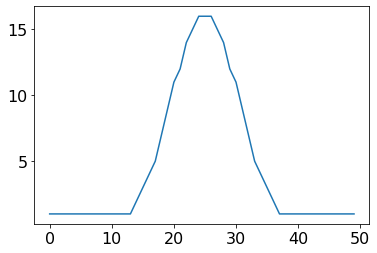

In [14]:
plt.plot(data[0,:,7])

In [15]:
wl0 = 0.5 * 10 ** (-6)
wl1 = 0.9 * 10 ** (-6)

def lin_int(x,x0,x1,y0,y1):
    y = y0+(y1-y0)*(x-x0)/(x1-x0)
    return y

def GT(temp,wavelength):
    param1 = h * 2 * c ** 2
    param2 = h * c / k
    result_value = param1/(wavelength**5)/(np.exp(param2/(wavelength*temp))-1)
    return result_value

def integr(wl,f_array,qe_array,a,b,t):
    f_i = len(f_array[0,f_array[0,:]*10**(-9)<=wl])
    qe_i = len(qe_array[0,qe_array[0,:]*10**(-9)<=wl])
    f = lin_int(wl*10**9,f_array[0,f_i-1],f_array[0,f_i],f_array[1,f_i-1],f_array[1,f_i])
    qe = lin_int(wl*10**9,qe_array[0,qe_i-1],qe_array[0,qe_i],qe_array[1,qe_i-1],qe_array[1,qe_i])
    result = f*(a-b*(wl-wl0)/(wl1-wl0))*qe*GT(t,wl)*200
    return result

In [16]:
def process_itg(inten_array,qe_array,tr_array):
    def inte_solve(qe,a,b,t):
        result_f = []
        for i in range(6):
            funct = quad(integr,wl0,wl1,args=(tr_array,qe[i+2],a,b,t),epsabs = 1e-2, limit=5)[0]
            result_f.append(funct)
        return np.array(result_f)
    popt,cov = curve_fit(inte_solve,qe_array,inten_array,bounds=((0,0,500),(1,0.1,1958.2)),maxfev=100000)
    return popt[2],popt[0],popt[1]


In [17]:
target = data[:,11:40,11:40]
t_map = np.zeros((len(target[0]),len(target[0,0])))
Ea_map = np.zeros((len(target[0]),len(target[0,0])))
Eb_map = np.zeros((len(target[0]),len(target[0,0])))
for i in range(len(target[0])):
    for j in range(len(target[0,0])):
        popt = process_itg(target[2:,i,j],qe_array,tr_array)
        t_map[i,j]= popt[0]
        Ea_map[i,j]= popt[1]
        Eb_map[i,j]= popt[2]

C:\Users\Wang Zhaoyong\AppData\Local\Temp\ipykernel_7372\292358248.py:5: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  funct = quad(integr,wl0,wl1,args=(tr_array,qe[i+2],a,b,t),epsabs = 1e-2, limit=5)[0]


In [18]:
def ratio(inten_array,qe_array,tr_array):
    def inte_solve(qe,t):
        result_f = []
        base = quad(integr,wl0,wl1,args=(tr_array,qe[0],1,0,t),epsabs = 1e-2, limit=5)[0]
        for i in range(8):
            funct = quad(integr,wl0,wl1,args=(tr_array,qe[i],1,0,t),epsabs = 1e-2, limit=5)[0]/base
            result_f.append(funct)
        return np.array(result_f)
    popt,cov = curve_fit(inte_solve,qe_array,inten_array/inten_array[0],bounds=((500),(1958.2)),maxfev=100000)
    return popt[0]


In [19]:
target = data[:,11:40,11:40]
t_map = np.zeros((len(target[0]),len(target[0,0])))
for i in range(len(target[0])):
    for j in range(len(target[0,0])):
        popt = ratio(target[:,i,j],qe_array,tr_array)
        t_map[i,j]= popt

C:\Users\Wang Zhaoyong\AppData\Local\Temp\ipykernel_7372\1481225474.py:4: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  base = quad(integr,wl0,wl1,args=(tr_array,qe[0],1,0,t),epsabs = 1e-2, limit=5)[0]
C:\Users\Wang Zhaoyong\AppData\Local\Temp\ipykernel_7372\1481225474.py:6: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  pro

Soll Wert:
1726	1753	1771	1777	1771	1753	1726
1753	1784	1809	1818	1809	1784	1753
1771	1809	1842	1859	1842	1809	1771
1777	1818	1859	1900	1859	1818	1777
1771	1809	1842	1859	1842	1809	1771
1753	1784	1809	1818	1809	1784	1753
1726	1753	1771	1777	1771	1753	1726


In [20]:
print(t_map)

[[1139.98499102 1171.93496684 1179.8060114  1192.42081277 1245.91521922
  1240.63452644 1272.1949835  1293.13858747 1306.47222678 1320.30648162
  1340.57588389 1352.47606423 1359.59343003 1360.1962263  1358.06254509
  1360.1962263  1359.59343003 1352.47606423 1340.57588389 1320.30648162
  1306.47222678 1293.13858747 1272.1949835  1240.63452644 1245.91521922
  1192.42081277 1179.8060114  1171.93496684 1139.98499102]
 [1171.93496684 1201.39421926 1206.67516874 1235.96654803 1265.24457132
  1288.18519324 1312.14227764 1336.15293192 1352.47606423 1365.61279877
  1378.27723361 1390.13807521 1401.66344196 1402.1164019  1404.52516385
  1402.1164019  1401.66344196 1390.13807521 1378.27723361 1365.61279877
  1352.47606423 1336.15293192 1312.14227764 1288.18519324 1265.24457132
  1235.96654803 1206.67516874 1201.39421926 1171.93496684]
 [1179.8060114  1206.67516874 1220.747953   1263.76792235 1298.50617374
  1320.5848023  1349.66464481 1365.35048093 1384.10679896 1404.52516385
  1416.275236   14

In [21]:
print(Ea_map)

[[0.34421438 0.36217051 0.42104484 0.27039816 0.39309862 0.28242551
  0.45621398 0.44516745 0.4581405  0.46182233 0.46598246 0.45589781
  0.45188076 0.45442917 0.46537148 0.45442917 0.45188076 0.45589781
  0.46598246 0.46182233 0.4581405  0.44516745 0.45621398 0.28242551
  0.39309862 0.27039816 0.42104484 0.36217051 0.34421438]
 [0.36217051 0.37746114 0.43488631 0.43829015 0.23352927 0.44944821
  0.45389946 0.44595169 0.45589781 0.46421851 0.45375351 0.45937658
  0.45603002 0.46198577 0.45586232 0.46198577 0.45603002 0.45937658
  0.45375351 0.46421851 0.45589781 0.44595169 0.45389946 0.44944821
  0.23352927 0.43829015 0.43488631 0.37746114 0.36217051]
 [0.42104484 0.43488631 0.50156387 0.44673054 0.45007815 0.46655581
  0.45016907 0.45660796 0.45962521 0.45586232 0.4651386  0.46786117
  0.46341403 0.46016776 0.46341761 0.46016776 0.46341403 0.46786117
  0.4651386  0.45586232 0.45962521 0.45660796 0.45016907 0.46655581
  0.45007815 0.44673054 0.50156387 0.43488631 0.42104484]
 [0.270398

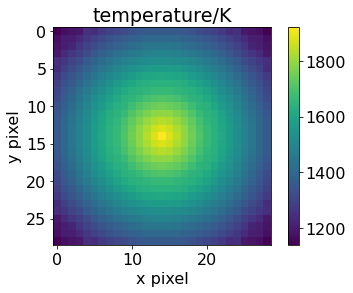

In [22]:
plt.clf()
im = plt.imshow(t_map)
plt.colorbar(im, orientation='vertical')
plt.xlabel("x pixel")
plt.ylabel("y pixel")
plt.rcParams.update({'font.size': 16})
plt.title("temperature/K")
plt.savefig(currentdir+"/filt_T.png")

In [12]:
print(process_itg(data[:,25,25],qe_array,tr_array))

C:\Users\ge83viz\AppData\Local\Temp\ipykernel_4044\2948883340.py:5: IntegrationWarning: The maximum number of subdivisions (5) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  funct = quad(integr,wl0,wl1,args=(tr_array,qe[i+2],a,b,t),epsabs = 1e-2, limit=5)[0]


ValueError: operands could not be broadcast together with shapes (6,) (8,) 

In [ ]:
print(Eb_map)

In [ ]:
print(np.mean(Ea_map-0.5*Eb_map))

In [ ]:
print(np.mean(t_map))

In [ ]:
wl0 = 0.5 * 10 ** (-6)
wl1 = 1 * 10 ** (-6)

def lin_int(x,x0,x1,y0,y1):
    y = y0+(y1-y0)*(x-x0)/(x1-x0)
    return y

def GT(temp,wavelength):
    param1 = h * 2 * c ** 2
    param2 = h * c / k
    result_value = param1/(wavelength**5)/(np.exp(param2/(wavelength*temp))-1)
    return result_value

def integr(wl,f_array,qe_array,a,b,t):
    f_i = len(f_array[0,f_array[0,:]*10**(-9)<=wl])
    qe_i = len(qe_array[0,qe_array[0,:]*10**(-9)<=wl])
    f = lin_int(wl*10**9,f_array[0,f_i-1],f_array[0,f_i],f_array[1,f_i-1],f_array[1,f_i])
    qe = lin_int(wl*10**9,qe_array[0,qe_i-1],qe_array[0,qe_i],qe_array[1,qe_i-1],qe_array[1,qe_i])
    result = 0.93*f*(a-b*(wl-wl0)/(wl1-wl0))*qe*GT(t,wl)*100
    return result

def process_itg(inten_array,qe_array,tr_array):
    def inte_solve(qe,a,b,t):
        result_f = []
        for i in range(8):
            funct = quad(integr,wl0,wl1,args=(tr_array,qe[i],a,b,t),epsabs = 1e-2, limit=5)[0]
            result_f.append(funct)
        return np.array(result_f)
    popt,cov = curve_fit(inte_solve,qe_array,inten_array,bounds=((0,0,500),(1,1,1958.2)),maxfev=100000)
    return popt[2],popt[0],popt[1]


In [ ]:
# wl0 = 0.5 * 10 ** (-6)
# wl1 = 1 * 10 ** (-6)
#
# def lin_int(x,x0,x1,y0,y1):
#     y = y0+(y1-y0)*(x-x0)/(x1-x0)
#     return y
#
# def GT(temp,wavelength):
#     param1 = h * 2 * c ** 2
#     param2 = h * c / k
#     result_value = param1/(wavelength**5)/(np.exp(param2/(wavelength*temp))-1)
#     return result_value
#
# def integr(wl,f_array,qe_array,a,t):
#     f_i = len(f_array[0,f_array[0,:]*10**(-9)<=wl])
#     qe_i = len(qe_array[0,qe_array[0,:]*10**(-9)<=wl])
#     f = lin_int(wl*10**9,f_array[0,f_i-1],f_array[0,f_i],f_array[1,f_i-1],f_array[1,f_i])
#     qe = lin_int(wl*10**9,qe_array[0,qe_i-1],qe_array[0,qe_i],qe_array[1,qe_i-1],qe_array[1,qe_i])
#     result = 0.93*f*a*qe*GT(t,wl)*100
#     return result
#
# def process_itg(inten_array,qe_array,tr_array):
#     def inte_solve(qe,a,t):
#         result_f = []
#         for i in range(4):
#             funct = quad(integr,wl0,wl1,args=(tr_array,qe[i+3],a,t),epsabs = 1e-2, limit=5)[0]
#             result_f.append(funct)
#         return np.array(result_f)
#     popt,cov = curve_fit(inte_solve,qe_array,inten_array[3:7],bounds=((0,500),(1,1958.2)),maxfev=100000)
#     return popt[1],popt[0]

In [ ]:
plt.clf()
im = plt.imshow(t_ori_map)
plt.colorbar(im, orientation='vertical')
plt.xlabel("x pixel")
plt.ylabel("y pixel")
plt.rcParams.update({'font.size': 16})
plt.title("temperature/K")
plt.savefig(currentdir+"/ori_T.png")

In [ ]:
print(t_ori_map)

In [ ]:
print(Ea_ori_map)

In [ ]:
print(Eb_map)

In [ ]:
print(Eb_ori_map)

In [ ]:
def inte_solve2(qe,a,t):
        result_f = []
        for i in range(4):
            funct = quad(integr,wl0,wl1,args=(tr_array,qe[i+3],a,t),epsabs = 1e-2, limit=10)[0]
            result_f.append(funct)
        return np.array(result_f)

In [ ]:
result_soll = inte_solve2(qe_array,0.87,0,1050.15)
result_cal = inte_solve2(qe_array,0.269666,0,1127)
meas = denoise[:,60,80]-noise
ori = data[0,60,80,:]-noise
plt.plot(meas[3:7],"--",label="meas")
plt.plot(ori[3:7],"--",label="ori")
plt.plot(result_cal*ex_factor/inte_sens[3:7],"--",label="cal")
plt.plot(result_soll*ex_factor/inte_sens[3:7],"--",label="soll")
plt.legend()